# Random Forest
---

Segun el paper con un clasificador basado en Random Forest deberiamos lograr un AUC de 1. Entrenar un Random Forest con búsqueda de hiperparametros que logre un AUC de 1 (¿cómo conviene elegir los datos de validación respecto de los de train?). El modelo debe cumplir las siguientes condiciones:

* Deben utilizar AUC-ROC como métrica de validación.
* Deben medirse solo en validación, no contra test!!!
* Deben ser reproducibles (correr el notebook varias veces no afecta al resultado).
* Deben tener un score en validación igual a 1.

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from feature_engine.encoding import MeanEncoder
from sklearn.metrics import roc_auc_score
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pickle

In [3]:
df = pd.read_csv('data/secondary_data.csv', sep=';')
df

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,p,15.26,x,g,o,f,e,NaN,w,16.95,...,s,y,w,u,w,t,g,NaN,d,w
1,p,16.60,x,g,o,f,e,NaN,w,17.99,...,s,y,w,u,w,t,g,NaN,d,u
2,p,14.07,x,g,o,f,e,NaN,w,17.80,...,s,y,w,u,w,t,g,NaN,d,w
3,p,14.17,f,h,e,f,e,NaN,w,15.77,...,s,y,w,u,w,t,p,NaN,d,w
4,p,14.64,x,h,o,f,e,NaN,w,16.53,...,s,y,w,u,w,t,p,NaN,d,w
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61064,p,1.18,s,s,y,f,f,f,f,3.93,...,NaN,NaN,y,NaN,NaN,f,f,NaN,d,a
61065,p,1.27,f,s,y,f,f,f,f,3.18,...,NaN,NaN,y,NaN,NaN,f,f,NaN,d,a
61066,p,1.27,s,s,y,f,f,f,f,3.86,...,NaN,NaN,y,NaN,NaN,f,f,NaN,d,u
61067,p,1.24,f,s,y,f,f,f,f,3.56,...,NaN,NaN,y,NaN,NaN,f,f,NaN,d,u


### Set de Validación

El set de validación se puede obtener de forma aleatoria ya que no hay una relación de orden o tiempo entre los datos. Aunque hay que asegurarse de también separar el set de test aunque no se vaya a usar en este notebook.

In [4]:
# Separo en train, test y validación.
X = df.drop(['class'], axis=1)
y = df['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
X_test, X_validacion, y_test, y_validacion = train_test_split(X_test, y_test, test_size=0.5, random_state=123)
# 80% train, 10% test, 10% validación.

In [5]:
# Imputo los valores nulos.
si = SimpleImputer(strategy='constant', fill_value='#')
X_train = pd.DataFrame(si.fit_transform(X_train), columns=X_train.columns)
X_validacion = pd.DataFrame(si.transform(X_validacion), columns=X_validacion.columns)

# Separo las variables continuas.
continuas = ['cap-diameter','stem-height','stem-width']
continuas_train = X_train[continuas].astype(float)
continuas_validacion = X_validacion[continuas].astype(float)

X_train.drop(continuas, axis=1, inplace=True)
X_validacion.drop(continuas, axis=1, inplace=True)

# Encodeo la variable target.
ohe = OneHotEncoder(drop='first', sparse_output=False)
y_train = ohe.fit_transform(y_train.values.reshape(-1,1))[:,0]
y_validacion = ohe.transform(y_validacion.values.reshape(-1,1))[:,0]

# Encodeo las variables categoricas.
ohe = OneHotEncoder(drop='if_binary', sparse_output=False)
ohe_columnas = ['does-bruise-or-bleed','gill-spacing','veil-type','has-ring','ring-type','habitat','season']
ohe_encodeadas_train = pd.DataFrame(ohe.fit_transform(X_train[ohe_columnas]))
ohe_encodeadas_validacion = pd.DataFrame(ohe.transform(X_validacion[ohe_columnas]))

me = MeanEncoder()
me_columnas = [x for x in df.columns if x not in ohe_columnas and x not in continuas and x != 'class']
me_encodeadas_train = me.fit_transform(X_train[me_columnas], y_train)
me_encodeadas_validacion = me.transform(X_validacion[me_columnas])

# Junto todo en sus 3 datasets.
columnas_me_ohe = me_columnas + [x for x in ohe.get_feature_names_out()]
X_train = pd.concat([me_encodeadas_train, ohe_encodeadas_train], axis=1)
X_validacion = pd.concat([me_encodeadas_validacion, ohe_encodeadas_validacion], axis=1)

X_train.columns = columnas_me_ohe
X_validacion.columns = columnas_me_ohe

X_train = pd.concat([X_train, continuas_train], axis=1)
X_validacion = pd.concat([X_validacion, continuas_validacion], axis=1)

In [6]:
rf = RandomForestClassifier(n_estimators=500, random_state=123)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=500, random_state=123)

## Auc Roc

In [7]:
prob_vali = rf.predict_proba(X_validacion)[:,-1]
print(f'Puntaje auc_roc en validación: {roc_auc_score(y_validacion, prob_vali)}')

Puntaje auc_roc en validación: 1.0


## Importancia de las Features

El random forest le dió una importancia muy distinta a la features que la regresión logística. Esto seguro se debe a que la regresión logística es un modelo muy simple para este problema y aunque se ajustó lo mejor que pudo no pudo lograr capturar la complejidad del problema.

In [8]:
features = pd.DataFrame({'feature': X_train.columns, 'importance': rf.feature_importances_})
features.feature = features.feature.map(lambda x: x.split('_')[0])
features = features.groupby('feature').sum().reset_index()
features.head()

,feature,importance
0,cap-color,0.066102
1,cap-diameter,0.059707
2,cap-shape,0.042373
3,cap-surface,0.083453
4,does-bruise-or-bleed,0.023053


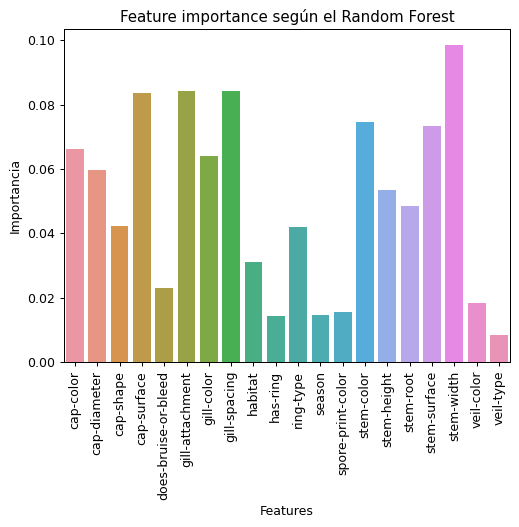

In [10]:
plt.figure(dpi=90)
sns.barplot(features, x='feature', y='importance')
plt.title('Feature importance según el Random Forest')
plt.xlabel('Features')
plt.ylabel('Importancia')
plt.xticks(rotation=90)
plt.show()

## Exporto el modelo para el ensamble con el XGBoost

In [11]:
pickle.dump(rf, open('modelos/rf.pkl', 'wb'))